# **Data Diri**

---
(Peserta Kampus merdeka - Student Indepentdent)


Nama : Gusti Muhammad Aulia Nur Sulthan

Alamat :  Kabupaten Hulu Sungai Selatan, Kalimantan Selatan

SIB Id : M247R6216

SIB Email : M247R6216@dicoding.org	

SIB Group : M3

# **Import Library dan Dataset**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

Sumber : [dataset](https://www.kaggle.com/aayushmishra1512/netflix-stock-data)

In [2]:
df = pd.read_csv('NFLX.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


In [3]:
# Total data
df.shape

(4581, 7)

In [6]:
# Check data
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [29]:
# Bagi data train dan validation
df_train = df[1:3601]
df_val = df[3602:4002]

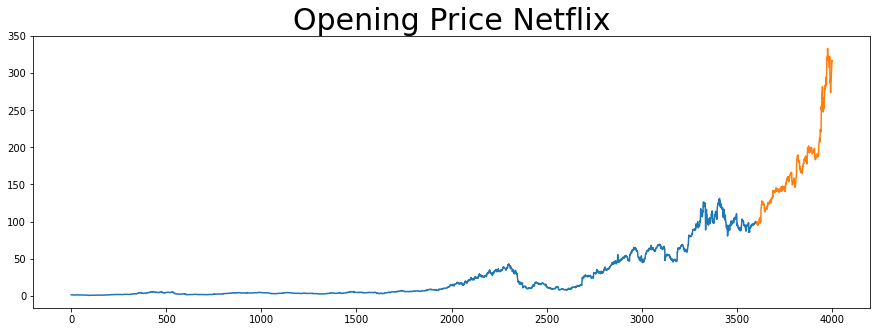

In [18]:
plt.figure(figsize=(15,5))
plt.plot(df_train.index, df_train['Open'])
plt.plot(df_val.index, df_val['Open'])
plt.title('Opening Price Netflix',
          fontsize=30);

Bagi data *Training* dan *Validation*

In [30]:
T_date = df_train['Date']
T_price = df_train['Open'].values

V_date = df_val['Date'].values
V_price = df_val['Open'].values

# reshape matrix
T_price_r = T_price.reshape(-1,1)
V_price_r = T_price.reshape(-1,1)

In [37]:
scaler = MinMaxScaler()
T_price_r_s = scaler.fit_transform(T_price_r)
V_price_r_s = scaler.fit_transform(T_price_r)

In [40]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

# **LSTM Model**

In [41]:
data_x_train = windowed_dataset(T_price_r_s, window_size=60, batch_size=68, shuffle_buffer=1000)
data_x_test = windowed_dataset(V_price_r_s, window_size=60, batch_size=68, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(128, return_sequences=True), 
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
    
  tf.keras.layers.Dense(60, activation="relu"),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-8)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [42]:
hist = model.fit(data_x_train ,epochs=65, validation_data=data_x_test, callbacks=[lr_schedule])

Epoch 1/65
53/53 [==============================] - 24s 321ms/step - loss: 5.1555 - mae: 5.5870 - val_loss: 5.1514 - val_mae: 5.5823
Epoch 2/65
53/53 [==============================] - 16s 298ms/step - loss: 5.1466 - mae: 5.5771 - val_loss: 5.1427 - val_mae: 5.5724
Epoch 3/65
53/53 [==============================] - 16s 296ms/step - loss: 5.1375 - mae: 5.5669 - val_loss: 5.1332 - val_mae: 5.5618
Epoch 4/65
53/53 [==============================] - 16s 297ms/step - loss: 5.1276 - mae: 5.5559 - val_loss: 5.1228 - val_mae: 5.5502
Epoch 5/65
53/53 [==============================] - 16s 300ms/step - loss: 5.1166 - mae: 5.5435 - val_loss: 5.1113 - val_mae: 5.5373
Epoch 6/65
53/53 [==============================] - 16s 300ms/step - loss: 5.1046 - mae: 5.5301 - val_loss: 5.0988 - val_mae: 5.5232
Epoch 7/65
53/53 [==============================] - 16s 297ms/step - loss: 5.0915 - mae: 5.5154 - val_loss: 5.0851 - val_mae: 5.5077
Epoch 8/65
53/53 [==============================] - 16s 305ms/step - 

**Plot MAE dan Loss**

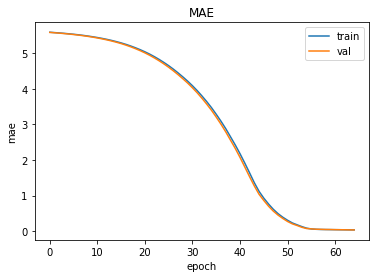

In [44]:
# plot MAE

plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train','val'])
plt.show()

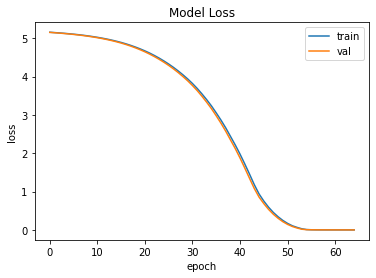

In [45]:
# plot loss

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'])
plt.show()